In [1]:
import matplotlib.pyplot as plt
from mxnet import autograd, gluon, nd, init, context
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from IPython import display
import numpy as np

In [20]:
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : Animator.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    @staticmethod
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
      """A utility function to set matplotlib axes"""
      axes.set_xlabel(xlabel)
      axes.set_ylabel(ylabel)
      axes.set_xscale(xscale)
      axes.set_yscale(yscale)
      axes.set_xlim(xlim)
      axes.set_ylim(ylim)
      if legend: axes.legend(legend)
      axes.grid()
    
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [2]:
def show_images(X, nrows, ncols):
    _, axes = plt.subplots(nrows, ncols)
    axes = axes.flatten()
    for ax, img in zip(axes, X):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return axes 

In [3]:
def get_dataloader(batch_size, resize=None, shuffle=True):
    transform_list = []
    if resize is not None:
        transform_list.append(transforms.Resize(resize))
    transform_list.append(transforms.ToTensor())
    transformer = transforms.Compose(transform_list)
    
    train = gluon.data.vision.datasets.FashionMNIST(train=True)
    train = train.transform_first(transformer)
    train_iter = gluon.data.DataLoader(train, batch_size, shuffle, num_workers=4)
    
    test = gluon.data.vision.datasets.FashionMNIST(train=False)
    test = test.transform_first(transformer)
    test_iter = gluon.data.DataLoader(test, batch_size, shuffle=False, num_workers=4)
    
    return train_iter, test_iter, train, test

In [13]:
class DenseBlock(nn.Block):
    def __init__(self,num_convs, growth_rate, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.network = nn.Sequential()
        for _ in range(num_convs):
            self.network.add(self.conv_block(growth_rate))
    def conv_block(self, num_channels):
        blk = nn.Sequential()
        blk.add(nn.BatchNorm())
        blk.add(nn.Activation('relu'))
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1))
        return blk
    def forward(self, X):
        for blk in self.network:
            Y = blk(X)
            
            X = nd.concat(X, Y, dim=1)
        return X

In [11]:
class DenseNet(nn.Block):
    def __init__(self, **kwargs):
        super(DenseNet, self).__init__(**kwargs)
        self.network = self.get_network()
    def __getitem__(self, key):
        return self.network[i]
    def __len__(self):
        return len(self.network)
    def transition_block(self, num_channels):
        blk = nn.Sequential()
        blk.add(nn.BatchNorm())
        blk.add(nn.Activation('relu'))
        blk.add(nn.Conv2D(num_channels, kernel_size=1))
        blk.add(nn.AvgPool2D(pool_size=2, strides=2))
        return blk
    def get_network(self):
        net = nn.Sequential()
        net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3))
        net.add(nn.BatchNorm())
        net.add(nn.Activation('relu'))
        net.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
        num_channels = 64
        growth_rate = 32
        num_convs = [4, 4, 4, 4]
        for i, c in enumerate(num_convs):
            net.add(DenseBlock(c, growth_rate))
            num_channels += c * growth_rate
            if i != len(num_convs)-1:
                num_channels //= 2
                net.add(self.transition_block(num_channels))
        net.add(nn.BatchNorm())
        net.add(nn.Activation('relu'))
        net.add(nn.GlobalAvgPool2D())
        net.add(nn.Dense(10))
        return net
    def forward(self, X):
        X = self.network(X)
        return X

In [6]:
batch_size = 4
train_iter, test_iter, train, test = get_dataloader(batch_size, resize=96, shuffle=False)

(4, 1, 96, 96)
(4,)


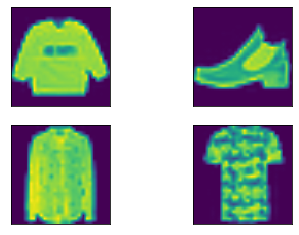

In [7]:
for X, y in train_iter:
    print(X.shape)
    print(y.shape)
    show_images(X.squeeze(axis=1).asnumpy(), 2, 2)
    break

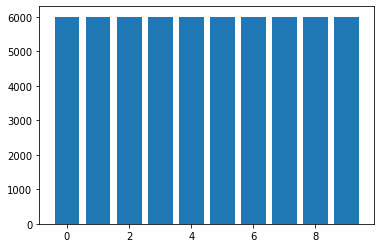

In [8]:
trainX, trainY = train[:]
unique, counts = np.unique(trainY, return_counts=True)
plt.bar(unique, counts)
plt.show()

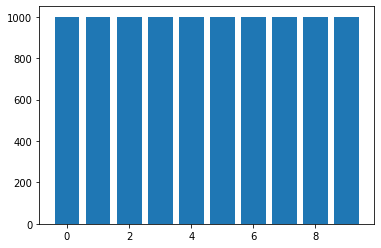

In [9]:
testX, testY = test[:]
unique, counts = np.unique(testY, return_counts=True)
plt.bar(unique, counts)
plt.show()

In [17]:
ctx = context.gpu()
net = DenseNet()
net.initialize(init=init.Xavier(), ctx=ctx)
x = nd.random.normal(shape=(1, 1, 96, 96), ctx=ctx)
for i in range(len(net)):
    layer = net[i]
    x = layer(x)
    print(layer.name, x.shape)

conv61 (1, 64, 48, 48)
batchnorm64 (1, 64, 48, 48)
relu64 (1, 64, 48, 48)
pool16 (1, 64, 24, 24)
denseblock13 (1, 192, 24, 24)
sequential80 (1, 96, 12, 12)
denseblock14 (1, 224, 12, 12)
sequential86 (1, 112, 6, 6)
denseblock15 (1, 240, 6, 6)
sequential92 (1, 120, 3, 3)
denseblock16 (1, 248, 3, 3)
batchnorm84 (1, 248, 3, 3)
relu84 (1, 248, 3, 3)
pool20 (1, 248, 1, 1)
dense3 (1, 10)


In [18]:
print(x)


[[-0.0132034   0.09813713  0.04363178 -0.13270727  0.01422592  0.09507618
  -0.14386451 -0.04419979 -0.05845089 -0.13445967]]
<NDArray 1x10 @gpu(0)>


In [19]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()
print(loss(x, nd.array([1]).copyto(ctx)).sum())


[2.180623]
<NDArray 1 @gpu(0)>


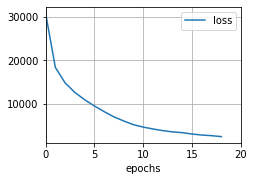

In [ ]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':3e-3})
epochs = 20
animator = Animator(xlabel='epochs', xlim=[0, epochs], legend=['loss'])

for epoch in range(epochs):
    epoch_loss = 0
    for X, y in train_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
        epoch_loss += l.sum().asscalar()
    animator.add(epoch, (epoch_loss))